In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import skew

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

#quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])
quantiles = np.array([0.03, 0.16, 0.5, 0.84, 0.97])
#inChannels = ['C34', 'C41', 'C42', 'C43']
dtb_max_meas = 15
quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])

## Read three and four channel input data

In [3]:
from aws_test_data import awsTestData

c183   = "C32"
c325_3 = "C4X"
c325_4 = "C41"

option3a = True

inChannels_3 = np.array([c183, c325_3])

if option3a:
    test_data_3  = awsTestData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/testing_data_noise_three_a.nc",
               inChannels_3, option = 3)    

inChannels_4 = np.array([c183, 'C41', 'C42', 'C43', 'C44'])
test_data_4 = awsTestData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/testing_data_noise_four.nc", 
               inChannels_4, option = 4)     

[2, 7]
[2, 8, 9, 10, 11]


## Load the QRNN model for three and four channel option

In [4]:
if option3a:
    qrnn_3 = QRNN.load('option3a_qrnn_models_3sigma/qrnn_4_256_%s_4X.nc'%c183)
    
qrnn_4 = QRNN.load('option4_qrnn_models_3sigma/qrnn_4_128_%s.nc'%c183)

In [5]:
i183   = np.argwhere(inChannels_3 == c183)[0,0]
i325_3 = np.argwhere(inChannels_3 == c325_3)[0,0]
i325_4 = np.argwhere(inChannels_4 == c325_4)[0,0]
print (i183, i325_3, i325_4)

0 1 1


In [6]:
def predict(test_data, qrnn):
    """
    predict the posterior mean and median
    """
    x = (test_data.x - test_data.mean)/test_data.std

    y_pre = qrnn.predict(x.data)
    y_prior = test_data.x
    y0 = test_data.y0
    y = test_data.y
    y_pos_mean = qrnn.posterior_mean(x.data)
    
    return y_pre, y_prior, y0, y, y_pos_mean
    

In [7]:
def calculate_pdf(y_pre, y_prior, y0, y, y_pos_mean, bins, iq, im):

    dtb_pre      = y_pre[:, iq] - y0
    dtb_prior    = y_prior[:, 0] - y0
    dtb_pos_mean = y_pos_mean - y0
    noise        = y - y0

    hist_noise    = np.histogram(noise, bins, density = True)
    hist_pre      = np.histogram(dtb_pre, bins, density = True)
    hist_prior    = np.histogram(dtb_prior, bins, density = True)
    hist_pos_mean = np.histogram(dtb_pos_mean[im], bins, density = True)
    
    return hist_noise, hist_pre, hist_prior, hist_pos_mean

In [8]:
def calculate_bias(y_prior, y0, y, y_pos_mean, im): 
    b0  = np.mean(y - y0)
    b1  = np.mean(y_prior[:, 0] - y0)
    b2a = np.mean(y_pos_mean - y0) 
    b2b = np.mean(y_pos_mean[im] - y0[im])
    return b0, b1, b2a, b2b

In [9]:
def calculate_mae(y_prior, y0, y, y_pos_mean, im): 
    mae0  = np.mean(abs(y - y0))
    mae1  = np.mean(abs(y_prior[:, 0] - y0))
    mae2a = np.mean(abs(y_pos_mean - y0)) 
    mae2b = np.mean(abs(y_pos_mean[im] - y0[im]))
    return mae0, mae1, mae2a, mae2b

In [10]:
def calculate_std(y_prior, y0, y, y_pos_mean, im):  
    std0  = np.std(y - y0)
    std1  = np.std(y_prior[:, 0] - y0)
    std2a = np.std(y_pos_mean - y0)
    std2b = np.std(y_pos_mean[im] - y0[im])
    return std0, std1, std2a, std2b

In [11]:
def calculate_skew(y_prior, y0, y, y_pos_mean, im):
    skew0  = skew(y - y0)
    skew1  = skew(y_prior[:, 0] - y0)
    skew2a = skew(y_pos_mean - y0)
    skew2b = skew(y_pos_mean[im] - y0[im])
    return skew0, skew1, skew2a, skew2b

## predict the expectation value

In [12]:
y_pre_3, y_prior_3, y0, y_3, y_pos_mean_3 = predict(test_data_3, qrnn_3)
y_pre_4, y_prior_4, y0, y_4, y_pos_mean_4 = predict(test_data_4, qrnn_4)


In [13]:
im_3 = np.abs(y_prior_3[:, i325_3] - y_prior_3[:, i183]) <= dtb_max_meas 
im_4 = np.abs(y_prior_4[:, i325_4] - y_prior_4[:, i183]) <= dtb_max_meas 


binstep = 0.5
bins = np.arange(-30, 8, binstep)
iq = np.argwhere(quantiles == 0.5)[0,0]

## calculate and plot the PDF of deviations


In [14]:

hist_noise_3, hist_pre_3, hist_prior_3, hist_pos_mean_3 = calculate_pdf(y_pre_3, y_prior_3, y0, y_4, y_pos_mean_3, bins, iq, im_3)

hist_noise_4, hist_pre_4, hist_prior_4, hist_pos_mean_4 = calculate_pdf(y_pre_4, y_prior_4, y0, y_4, y_pos_mean_4, bins, iq, im_4)

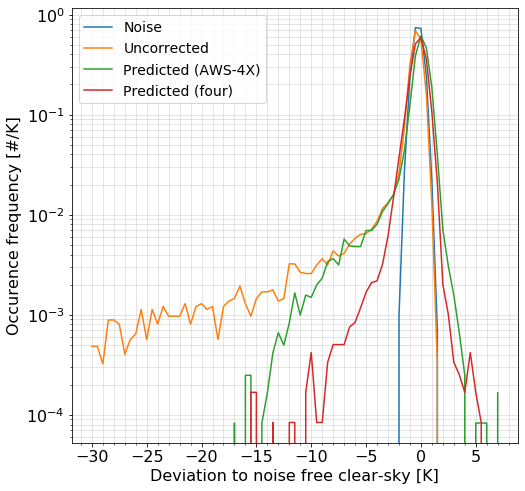

In [18]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(bins[:-1], hist_noise_4[0])
ax.plot(bins[:-1], hist_prior_4[0])
#ax.plot(bins[:-1], hist_pre_4[0])
ax.plot(bins[:-1], hist_pos_mean_3[0])
ax.plot(bins[:-1], hist_pos_mean_4[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)


ax.legend(["Noise", "Uncorrected", "Predicted (AWS-4X)", "Predicted (four)" ], prop={'size': 14})

#ax.set_title("Channel :%s"%inChannels[0])

fig.savefig('Figures/Channel_%s_C4X'%inChannels_3[0])

 ### Calculate different statistics

## THREE CHANNEL OPTION

In [16]:
b0, b1, b2a, b2b = calculate_bias(y_prior_3, y0, y_4, y_pos_mean_3, im_3)
mae0, mae1, mae2a, mae2b = calculate_mae(y_prior_3, y0, y_4, y_pos_mean_3, im_3)
std0, std1, std2a, std2b = calculate_std(y_prior_3, y0, y_4, y_pos_mean_3, im_3)
skew0 , skew1, skew2a, skew2b = calculate_skew(y_prior_3, y0, y_4, y_pos_mean_3, im_3)

from tabulate import tabulate
b = [b0, b1,  b2a, b2b]
mae = [mae0, mae1,  mae2a, mae2b]
std = [std0, std1,  std2a, std2b]
skewness = [skew0, skew1,  skew2a, skew2b]
rejected = 1 - np.sum(im_3)/im_3.size
rejected = [0, 0, 0, rejected * 100]

if option3a:
    sets = ['Noise', 'uncorrected', 'corrected', "corrected (three channela)"]#, 'corrected(1sigma)', 'sreerekha et al', 'filtered(1sigma)']

   
table  = [[sets[i], b[i], std[i], skewness[i], rejected[i]] for i in range(4)]
  
print(tabulate(table
         , ["Dataset","bias", "std", "measure skewness", 'rejected'],  tablefmt="latex", floatfmt=".3f"))

#table  = [[sets[i], b[i], mae[i], std[i], skewness[i], rejected[i]] for i in range(4)]
#print(tabulate(table
#         , ["Dataset","bias", "mae", "std", "measure skewness", 'rejected'],  tablefmt="latex", floatfmt=".3f"))

print (rejected)

\begin{tabular}{lrrrr}
\hline
 Dataset                    &   bias &   std &   measure skewness &   rejected \\
\hline
 Noise                      & -0.004 & 0.450 &             -0.030 &      0.000 \\
 uncorrected                & -1.343 & 5.900 &             -7.470 &      0.000 \\
 corrected                  & -0.107 & 1.934 &             -3.333 &      0.000 \\
 corrected (three channela) &  0.008 & 1.514 &             -4.085 &      3.678 \\
\hline
\end{tabular}
[0, 0, 0, 3.6784632552207874]


## FOUR CHANNEL OPTION

In [17]:
b0, b1, b2a, b2b = calculate_bias(y_prior_4, y0, y_4, y_pos_mean_4, im_4)
mae0, mae1, mae2a, mae2b = calculate_mae(y_prior_4, y0, y_4, y_pos_mean_4, im_4)
std0, std1, std2a, std2b = calculate_std(y_prior_4, y0, y_4, y_pos_mean_4, im_4)
skew0 , skew1, skew2a, skew2b = calculate_skew(y_prior_4, y0, y_4, y_pos_mean_4, im_4)
b = [b0, b1,  b2a, b2b]
mae = [mae0, mae1,  mae2a, mae2b]
std = [std0, std1,  std2a, std2b]
skewness = [skew0, skew1,  skew2a, skew2b]
rejected = 1 - np.sum(im_4)/im_4.size 
rejected = [0, 0, 0, rejected * 100]


sets = ['Noise', 'uncorrected', 'corrected', "corrected (four channel)"]#, 'corrected(1sigma)', 'sreerekha et al', 'filtered(1sigma)']

table  = [[sets[i], b[i], std[i], skewness[i], rejected[i]] for i in range(4)]

print(tabulate(table
         , ["Dataset","bias", "std", "measure skewness", 'rejected'],  tablefmt="latex", floatfmt=".3f"))

#table  = [[sets[i], b[i], mae[i], std[i], skewness[i], rejected[i]] for i in range(4)]
#print(tabulate(table
#         , ["Dataset","bias", "mae", "std", "measure skewness", 'rejected'],  tablefmt="latex", floatfmt=".3f"))


print (rejected)

\begin{tabular}{lrrrr}
\hline
 Dataset                  &   bias &   std &   measure skewness &   rejected \\
\hline
 Noise                    & -0.004 & 0.450 &             -0.030 &      0.000 \\
 uncorrected              & -1.343 & 5.908 &             -7.484 &      0.000 \\
 corrected                & -0.051 & 1.125 &             -2.278 &      0.000 \\
 corrected (four channel) & -0.011 & 0.878 &             -3.030 &      4.930 \\
\hline
\end{tabular}
[0, 0, 0, 4.92985812211063]
